# Visualize Weather Station Interactions on Map
This notebook contains code to load a trained encoder, predict latent interactions (probably on test set) and finally visualize this graph on a map.

In [1]:
# Install plotting library if not already done
# !conda install basemap basemap-data-hires -y

### Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import torch
import os
import sys
from tqdm import tqdm

# Fix error in case Basemap can't find epsg files, see https://github.com/matplotlib/basemap/issues/419
# You might need to adjust the path, e.g. your proj4-folder could have a slightly different name
os.environ['PROJ_LIB'] = "/nfs/homedirs/grafberg/anaconda3/pkgs/proj4-5.2.0-he6710b0_1/share/proj/"
sys.path.append("..")
%matplotlib inline

## Constants and Hyperparameters

Possible paths:  

    ("smoo_cnn_rnn_ts_14_edg_2_dyn_t_prior/Sat_Jun_15_23_44_28_2019-9223",)
    "smoo_cnn_rnn_ts_14_edg_2_dyn_t_spars_prior/Sat_Jun_15_23_42_57_2019-9223",
    "smoo_cnn_rnn_ts_14_edg_4_dyn_t_spars_prior/Sat_Jun_15_23_43_03_2019-9223"

In [3]:
from src.model import utils

#### Paths and configuration regarding encoder
BASE_PATH = "/nfs/students/summer-term-2019/project-4/logs/weather/nri/" \
            "smoo_cnn_rnn_ts_14_edg_2_dyn_t_spars_prior/Sat_Jun_15_23_42_57_2019-9223"
MODEL_BASE_PATH = os.path.join(BASE_PATH, "models")
CONFIG_PATH = os.path.join(BASE_PATH, "config.json")
EPOCH = utils.find_latest_checkpoint(MODEL_BASE_PATH)
config = json.load(open(CONFIG_PATH, "rt"))


# Relevant information about data set
dataset = config['data']['name']
n_features = config['data'][dataset]['dims']
n_atoms = config['data'][dataset]['atoms']
n_edge_types = config['model']['n_edge_types']
timesteps = config['data']['timesteps']


# Set data location
DATA_PATH = os.path.abspath("/nfs/students/summer-term-2019/project-4/datasets/weather/100000_5_100_1_0_raw.pickle") 
STATION_INFOS_PATH = os.path.abspath("/nfs/students/summer-term-2019/project-4/andreas/project-4/notebooks/stations_coordinates.pickle")


In [4]:
# Load test set and information about stations
with open(DATA_PATH, "rb") as f:
    data_dict = pickle.load(f)
    
with open(STATION_INFOS_PATH, "rb") as f:
    station_infos = pickle.load(f)

data = data_dict['test_set'] # Contains test set and all time series
configs = data_dict['test_configurations'] # Which stations represent individual sequences
config_indices = data_dict['test_config_indices'] # How to lookup configurations

# Extract Latent Graphs with Encoder

In [5]:
# Load Encoder
from src.model.utils import load_weights, gen_fully_connected
from torch.utils.data import DataLoader, TensorDataset
from train import create_encoder
import torch

# Change to device('cuda:0') e.g. to run on GPU
device = torch.device('cuda:3')

# Load model as defined in config and 
encoder = create_encoder(config).to(device)
encoder.load_state_dict(torch.load(os.path.join(MODEL_BASE_PATH, f"encoder_epoch{EPOCH}.pt"), map_location='cpu'))
print(f"Successfully loaded encoder from epoch {EPOCH}")
# Move data to GPU if used
data_tensor = torch.Tensor(data).to(device)
data_loader = DataLoader(TensorDataset(data_tensor), batch_size=128, shuffle=False) # TODO: Wrap in dataloader

rel_rec, rel_send = gen_fully_connected(n_atoms, device=device)

../src/model/modules.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
../src/model/modules.py:156: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


Using factor graph CNN encoder.
Successfully loaded encoder from epoch 11


## Run test set through encoder and extract graphs

In [6]:
from src.model.utils import gumbel_softmax, edges_to_adj

encoder.eval()
graphs = np.empty((0, n_edge_types, n_atoms, n_atoms))

for batch_id, (batch,) in tqdm(enumerate(data_loader)):
    # Only use 'timesteps'- number of values to infer latent graph
    batch = batch[:, :, :timesteps, :].to(device)

    logits = encoder(batch, rel_rec, rel_send)
    edges = gumbel_softmax(logits, tau=0.5, hard=True).cpu()
    graphs_batch = edges_to_adj(edges, n_atoms=n_atoms)
    graphs = np.concatenate((graphs, graphs_batch), axis=0)

0it [00:00, ?it/s]../src/model/utils.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)
79it [00:02, 37.43it/s]


In [7]:
# Distances are normalized between 0 and 1 to match
# the latent graph activations
with open("/nfs/students/summer-term-2019/project-4/paul/notebooks/station_distances.pickle", "rb") as f:
    station_distances = pickle.load(f)

def compare_graph_with_distances(sample_id, rel_ix, corr=None):
        
    graph_to_compare = graphs[sample_id][rel_ix] if corr is None else corr
    stations = configs[config_indices[sample_id] - config_indices[0]]
    
    loss = 0.0
    
    # Check the graph symetrically, omitting the diagonal
    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            dist = station_distances[stations[i]][stations[j]]
            
            # Reverses the distances, i.e. makes longest distance 0 and shortest distance 1
            dist = abs(dist-1)
            
            # Both symmetric entries over and under the diagonal are checked against the distance.
            # This is done with the assumption that most relationships will be bi-directional
            loss += abs(graph_to_compare[i][j] - dist)
            loss += abs(graph_to_compare[j][i] - dist)
            
    # Return mean error
    return loss/(n_atoms*(n_atoms-1))

len(graphs)

10000

In [8]:
losses = []
corr_loss = []

for rel in range(n_edge_types):
    losses.append([])
for g in range(len(graphs)):
    corr = np.corrcoef(data[g, :, :, 0])
    corr_loss.append(compare_graph_with_distances(g, rel, corr))
    for rel in range(n_edge_types):
        losses[rel].append(compare_graph_with_distances(g, rel))

for loss_ix in range(len(losses)):
    print("Rel {} latent graph error: {}".format(loss_ix, sum(losses[loss_ix])/len(losses[loss_ix])))
print("Correlation matrix error: {}".format(sum(corr_loss)/len(corr_loss)))

Rel 0 latent graph error: 0.6140316951464694
Rel 1 latent graph error: 0.38596830485353006
Correlation matrix error: 0.13541186809358083


## On to the fun part - Visualizations

### Create Map to plot on
As our data set's weather stations are located in Spain, the below used coordinates represent a square fully comprising Spain.

In [9]:
from src.model.utils import id_2_loc, edges_to_adj
from mpl_toolkits.basemap import Basemap

# Map to plot weather stations
map = Basemap(projection='lcc', resolution='l',
            width=1.5E6, height=1.5E6,#width=3E6, height=3E6, #
            lat_0=39, lon_0=-4.5) #lat_0=38, lon_0=-2.5)  #

In [10]:
from weather.utils import plot_interactions

def plot_configuration(index, ax=None, skip_first=True):
    
    if ax is None:
        _, ax = plt.subplots(1, figsize=(15, 15))
    
    configuration = configs[config_indices[sample_id] - config_indices[0]]
    locations = [(station_infos[i]['long'], station_infos[i]['lat']) for i in configuration]

    plot_interactions(locations, graphs[sample_id], ax=ax, map=map, skip_first=True)

def get_sample_ids_with_configuration(config_id):
    sample_ids = [i for i, val in enumerate(config_indices) if val == config_id]
    return sample_ids

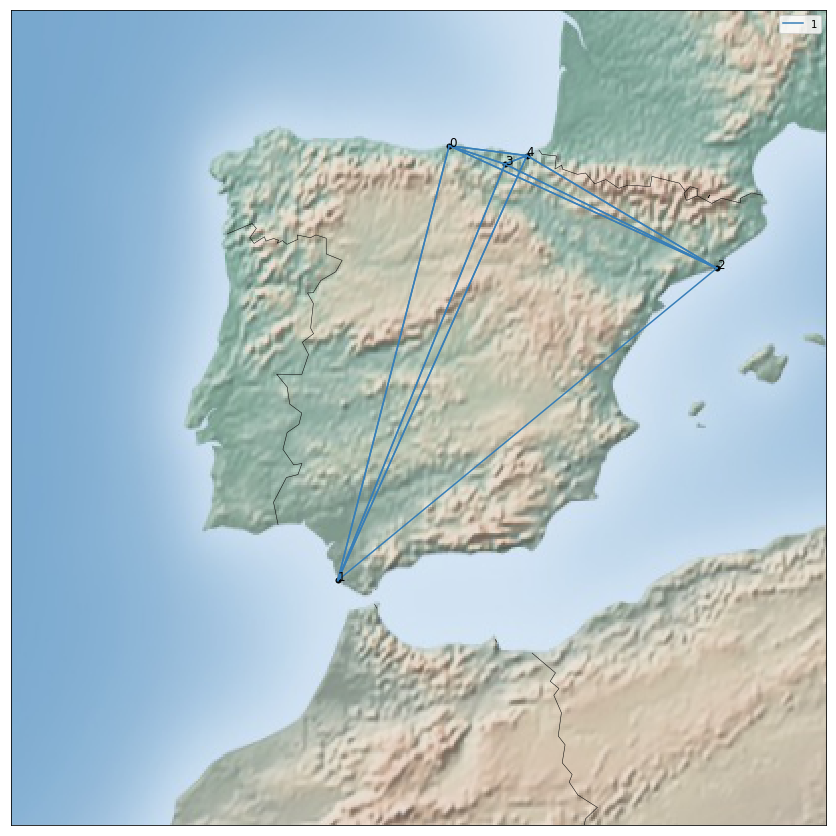

In [11]:
# Plot interactions on Map
sample_id = 3
plot_configuration(sample_id)
#plt.savefig(f"final_plots/2_sparse_id_{sample_id}_map.png", dpi=200)

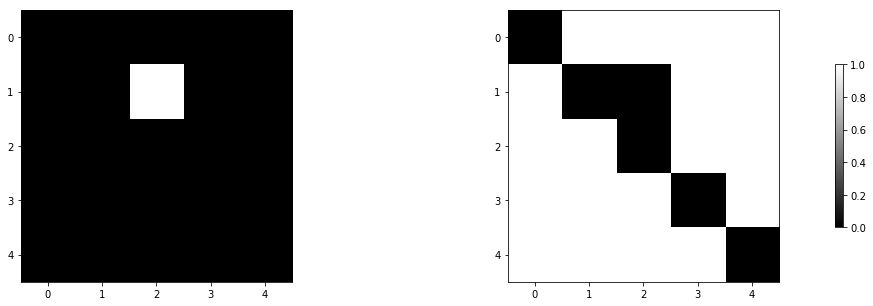

In [12]:
# Visualize adjacency matrix
fig, axes = plt.subplots(nrows=1, ncols=n_edge_types, figsize=(20, 5))
for i in range(n_edge_types):
    im = axes[i].imshow(graphs[sample_id, i, :, :], cmap='gray', interpolation=None)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
#plt.savefig(f"final_plots/2_sparse_id_{sample_id}_adj.png", dpi=200)

In [13]:
# Calculate average graph for a configuration:
print(f"There exists a total of {len(configs)} different configurations in our test set.")

There exists a total of 267 different configurations in our test set.


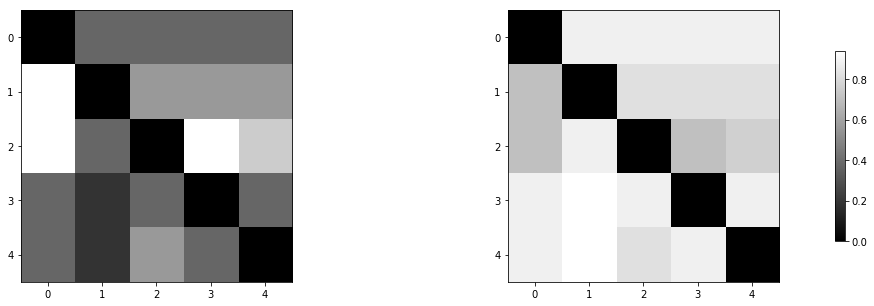

In [14]:
# Calculate average interactions for this configuration
indices = get_sample_ids_with_configuration(config_indices[sample_id])
fig, axes = plt.subplots(nrows=1, ncols=n_edge_types, figsize=(20, 5))
for i in range(n_edge_types):
    im = axes[i].imshow(graphs[indices, i, :, :].mean(axis=0), cmap='gray', interpolation=None)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
#plt.savefig(f"final_plots/2_sparse_id_{sample_id}_mean_adj.png", dpi=200)

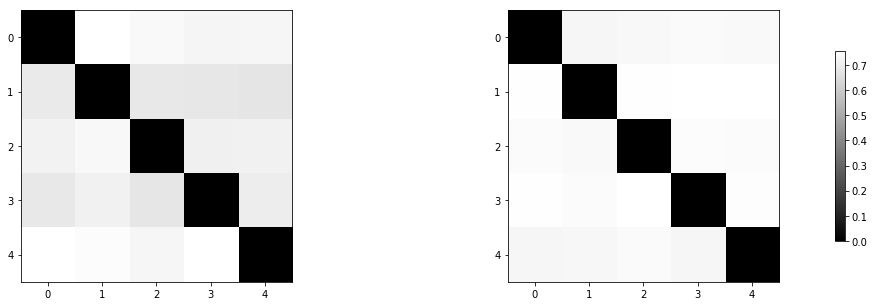

In [15]:
# Calculate average interactions across all samples
fig, axes = plt.subplots(nrows=1, ncols=n_edge_types, figsize=(20, 5))
for i in range(n_edge_types):
    im = axes[i].imshow(graphs[:, i, :, :].mean(axis=0), cmap='gray', interpolation=None)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)

## Simply show correlation matrix

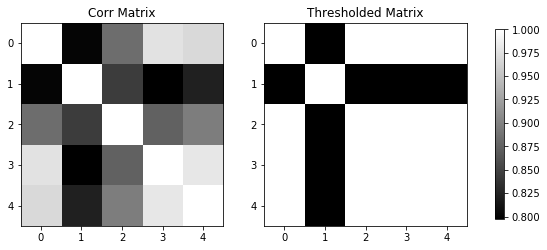

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
corr = np.corrcoef(data[sample_id, :, :, 0])
ax[0].set_title("Corr Matrix")
im = ax[0].imshow(corr, cmap='gray', interpolation=None)

ax[1].set_title("Thresholded Matrix")
corr_thresh = corr > np.percentile(corr, 30)
ax[1].imshow(corr_thresh, cmap='gray', interpolation=None)
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.7)
#fig.savefig(f"final_plots/corr_id_{sample_id}")

## Let's see how the latent graph changes over time


In [17]:
from matplotlib.animation import FuncAnimation

def latent_graph_dynamic(sample_id):
    dynamic_graphs = []
    sliding_windows = []
    for step in range(0, 100 - timesteps): #data_tensor.size(-2) - timesteps):
        # Use sliding window to update latent graph over timesteps
        input = data_tensor[sample_id:sample_id+1, :, step:step+timesteps, :]
        logits = encoder(input, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=0.5, hard=True).cpu()
        graphs = edges_to_adj(edges, n_atoms=n_atoms)
        
        dynamic_graphs.append(graphs)
        sliding_windows.append(input[0].cpu().detach().numpy())
        
    return np.asanyarray(sliding_windows), np.asanyarray(dynamic_graphs)[:,0,:,:,:]

def init_anim(data, graph, axarr=None):
    
    # Create axis to plot if not given
    n_edge_types = graph.shape[0]
    if axarr is None:
        fig, axarr = plt.subplots(nrows=1, ncols=1 + n_edge_types)
    else:
        assert(len(axarr) >= 1 + n_edge_types)
    
    # Plot data
    n_atoms = data.shape[0]
    data_plots = []
    axarr[0].set_ylim((-2.0, 2.0))
    axarr[0].set_title("Data (Sliding Window)")
    for atom in range(n_atoms):
        data_plots.append(axarr[0].plot(data[atom,:,0], label=f"Station {atom}")[0])
        
    axarr[0].legend()
        
        
    # Plot latent graphs
    
    graph_plots = []
    for i in range(n_edge_types):
        axarr[i + 1].set_title(f"Edge type #{i}")
        im = axarr[i + 1].imshow(graphs[0, i, :, :], cmap='gray', interpolation=None)
        graph_plots.append(im)
    
    return data_plots, graph_plots


def update_anim(step):
    global data_plots
    global graph_plots
    global sliding_windows
    global data
    global graphs
    
    
    step = int(step)
    n_atoms = data.shape[1]
    timesteps = data.shape[2]
    for atom in range(n_atoms):
        sequence = sliding_windows[step, atom, :, 0]
        new_data = (np.arange(len(sequence)), sequence)
        data_plots[atom].set_data(new_data)
        
    n_edge_types = graphs.shape[1]
    for i in range(n_edge_types):
        graph_plots[i].set_data(graphs[step, i, :, :])
    return (data_plots + graph_plots)

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


FileNotFoundError: [Errno 2] No such file or directory: 'final_plots/2_sparse_id_3_anim.gif'

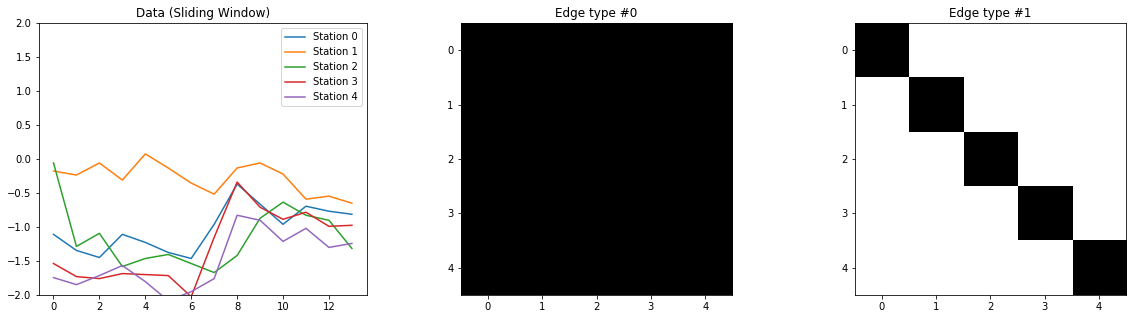

In [18]:
fig, axarr = plt.subplots(nrows=1, ncols=n_edge_types + 1, figsize=(20, 5))

sliding_windows, graphs = latent_graph_dynamic(sample_id)
data_plots, graph_plots = init_anim(sliding_windows[0], graphs[0], axarr=axarr)
    
ani = FuncAnimation(fig, update_anim, frames=len(graphs), interval=300, blit=True, repeat=True)
ani.save(f"final_plots/2_sparse_id_{sample_id}_anim.gif")